# **MILESTONE 1**


## **Cel biznesowy:** Segmentacja klientów banku na podstawie ich zachowań transakcyjnych i typów kont w celu personalizacji ofert marketingowych i zwiększenia retencji klientów

**Korzyści wynikające dla banku z racji takiego pogrupowania klientów:**

- Możliwość kierowania odpowiednich ofert do odpowiednich klientów (np. lokaty dla klientów z dużym saldem).

- Identyfikacja klientów wysokiego ryzyka lub niskiej aktywności.

- Możliwość tworzenia kampanii retencyjnych dla segmentów o niskim zaangażowaniu.

### Wczytanie ramki danych

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/banking_dataset.csv")

## **Eksploracja i wstępna analiza danych**

In [171]:
df.head()

,,Account ID;Customer Name;Account Type;Branch;Transaction Type;Transaction Amount;Account Balance;Currency
ACC00001;Amanda Pugh;Recurring Deposit;New York;Debit;2687,19;36676,19;GBP
ACC00002;Amanda Wilcox;Recurring Deposit;Houston;Debit;3886,77;28582,82;USD
ACC00003;Kimberly Valenzuela;Current;New York;Credit;2438,74;76599,56;GBP
ACC00004;Sonia Ballard;Recurring Deposit;Philadelphia;Credit;2758,53;62317,6;INR
ACC00005;Erika Russell;Current;Philadelphia;Debit;3287;85515,21;INR,NaN


Widzimy, że ramka danych po zapisaniu w pliku csv, nie ładuje się dobrze. Na szczęście jest na to rozwiązanie:

In [172]:
df = pd.read_csv("data/banking_dataset.csv", sep=";")


In [173]:
df.head()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
0,ACC00001,Amanda Pugh,Recurring Deposit,New York,Debit,"2687,19","36676,19",GBP
1,ACC00002,Amanda Wilcox,Recurring Deposit,Houston,Debit,"3886,77","28582,82",USD
2,ACC00003,Kimberly Valenzuela,Current,New York,Credit,"2438,74","76599,56",GBP
3,ACC00004,Sonia Ballard,Recurring Deposit,Philadelphia,Credit,"2758,53","62317,6",INR
4,ACC00005,Erika Russell,Current,Philadelphia,Debit,3287,"85515,21",INR


In [174]:
df.tail()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
9995,ACC09996,Richard Davis,Fixed Deposit,New York,Debit,"400,96","38035,17",USD
9996,ACC09997,Lauren Weber,Savings,Chicago,Debit,"3736,7","60682,41",EUR
9997,ACC09998,Nichole Stout,Fixed Deposit,Houston,Credit,"4002,91","36136,11",USD
9998,ACC09999,Kristen Wilkinson,Fixed Deposit,Philadelphia,Debit,"866,9","35644,82",GBP
9999,ACC10000,Brian Sandoval,Fixed Deposit,Philadelphia,Debit,"3932,81","32357,51",GBP


In [175]:
df.shape

(10000, 8)

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Account ID          10000 non-null  object
 1   Customer Name       10000 non-null  object
 2   Account Type        10000 non-null  object
 3   Branch              10000 non-null  object
 4   Transaction Type    10000 non-null  object
 5   Transaction Amount  10000 non-null  object
 6   Account Balance     10000 non-null  object
 7   Currency            10000 non-null  object
dtypes: object(8)
memory usage: 625.1+ KB


wszysktie kolumny są typu object - trzeba będzie to zmienić 

In [177]:
print(df.isnull().sum())

Account ID            0
Customer Name         0
Account Type          0
Branch                0
Transaction Type      0
Transaction Amount    0
Account Balance       0
Currency              0
dtype: int64


Brak pustych wartości

In [178]:
df.describe()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,10000,9323,4,8,2,9896,9995,5
top,ACC00001,William Williams,Savings,Philadelphia,Credit,"3398,97","21317,69",JPY
freq,1,7,2580,1288,5114,3,2,2041


## Po wstępnej analizie kolumn, usunięte zostaną kolumny 'Account ID' oraz 'Customer Name', są to informacje, które nie wnoszą żadnej informacji

In [179]:
df = df.drop(['Account ID', 'Customer Name'], axis = 1)

In [180]:
df.head()

,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
0,Recurring Deposit,New York,Debit,"2687,19","36676,19",GBP
1,Recurring Deposit,Houston,Debit,"3886,77","28582,82",USD
2,Current,New York,Credit,"2438,74","76599,56",GBP
3,Recurring Deposit,Philadelphia,Credit,"2758,53","62317,6",INR
4,Current,Philadelphia,Debit,3287,"85515,21",INR


In [181]:
 df.drop_duplicates(inplace=True)

Możemy teraz przejść do dalszej eksploracji danych, najpierw zmieńmy typy danych w kolumnach, aby móc operować na zmiennych liczbowych

In [182]:
#df['Transaction Amount'] = pd.to_numeric(df['Transaction Amount'], errors='coerce')
#df['Account Balance'] = pd.to_numeric(df['Account Balance'], errors='coerce')

df['Transaction Amount'] = df['Transaction Amount'].str.replace(',', '.').astype(float)
df['Account Balance'] = df['Account Balance'].str.replace(',', '.').astype(float)

Sprawdźmy unikalne wartości i ich ilość dla poszczególnych kolumn

In [183]:
print(df.dtypes)

Account Type           object
Branch                 object
Transaction Type       object
Transaction Amount    float64
Account Balance       float64
Currency               object
dtype: object


In [184]:

for col in ['Account Type', 'Branch', 'Transaction Type', 'Currency']:
    print(f"\nUnikalne wartości w kolumnie {col}:")
    print(df[col].value_counts())


Unikalne wartości w kolumnie Account Type:
Account Type
Savings              2580
Current              2529
Fixed Deposit        2489
Recurring Deposit    2402
Name: count, dtype: int64

Unikalne wartości w kolumnie Branch:
Branch
Philadelphia    1288
Phoenix         1274
Los Angeles     1268
Houston         1259
New York        1256
Chicago         1239
San Antonio     1233
San Diego       1183
Name: count, dtype: int64

Unikalne wartości w kolumnie Transaction Type:
Transaction Type
Credit    5114
Debit     4886
Name: count, dtype: int64

Unikalne wartości w kolumnie Currency:
Currency
JPY    2041
EUR    2039
USD    2035
GBP    1958
INR    1927
Name: count, dtype: int64


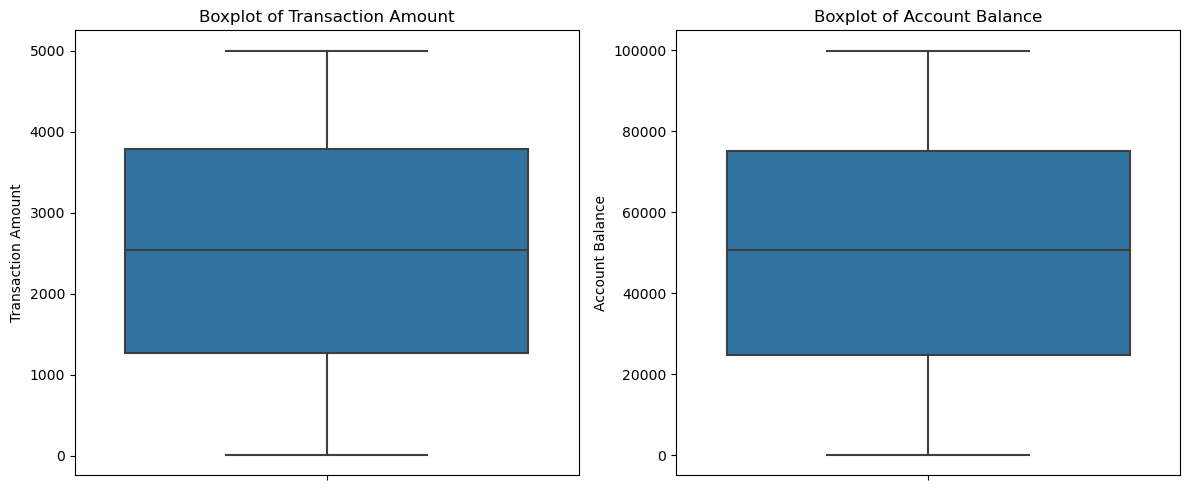

In [185]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Transaction Amount'])
plt.title('Boxplot of Transaction Amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Account Balance'])
plt.title('Boxplot of Account Balance')
plt.tight_layout()
plt.show()

**Nie ma widocznych żadnych outlierów.**

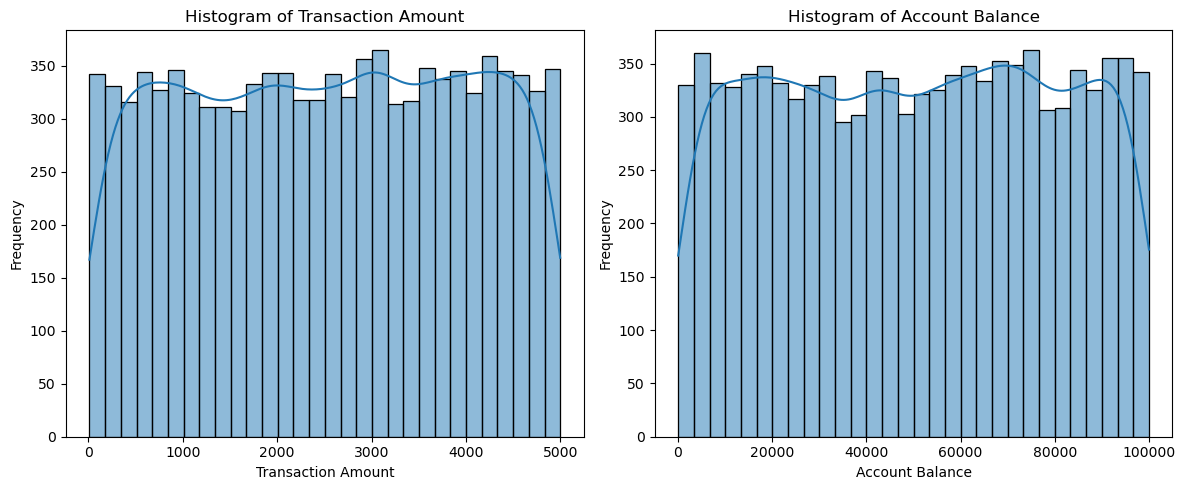

In [186]:

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for Transaction Amount
plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount'], bins=30, kde=True)
plt.title('Histogram of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Histogram for Account Balance
plt.subplot(1, 2, 2)
sns.histplot(df['Account Balance'], bins=30, kde=True)
plt.title('Histogram of Account Balance')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

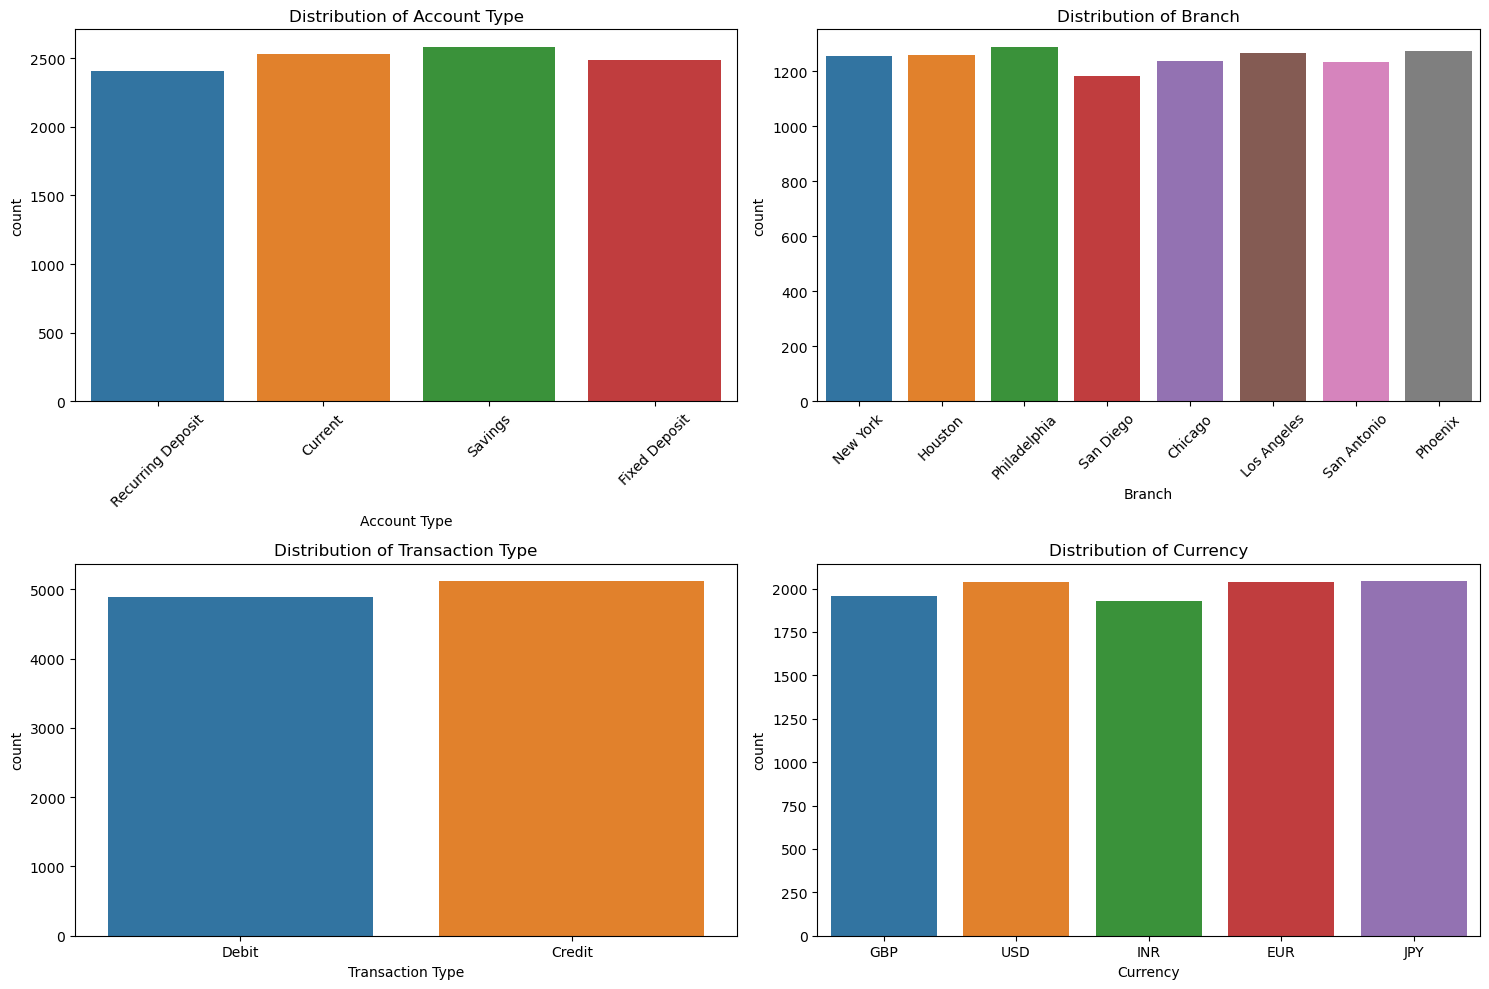

In [187]:
# Count plots for categorical variables
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.countplot(x='Account Type', data=df)
plt.title('Distribution of Account Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.countplot(x='Branch', data=df)
plt.title('Distribution of Branch')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.countplot(x='Transaction Type', data=df)
plt.title('Distribution of Transaction Type')

plt.subplot(2, 2, 4)
sns.countplot(x='Currency', data=df)
plt.title('Distribution of Currency')
plt.tight_layout()
plt.show()


Dla każdej zmiennej kategorycznej zliczenia możliwych wartości są rozłożone mniej więcej po równo.

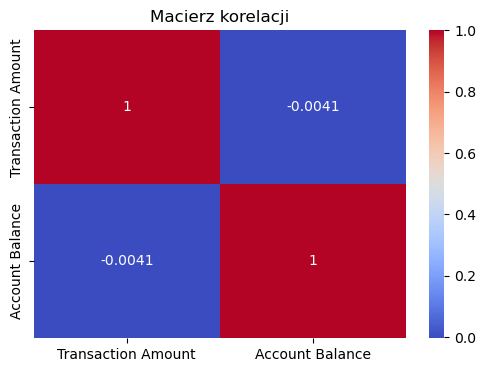

In [188]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

Pomiędzy zmiennymi numerycznymi nie zachodzi korelacja

In [189]:
print(df.groupby('Account Type')['Transaction Amount'].mean())

print(df.groupby('Currency')['Account Balance'].mean())


Account Type
Current              2502.820059
Fixed Deposit        2546.617151
Recurring Deposit    2512.312627
Savings              2536.010089
Name: Transaction Amount, dtype: float64
Currency
EUR    50502.715473
GBP    49906.100516
INR    51049.621271
JPY    49827.480314
USD    50091.525027
Name: Account Balance, dtype: float64


Nie widać na piewrszy rzut oka żadnej zależności pomiędzy średnią wartością transakcji/stanem konta a walutą w jakiej prowadzone jest konto

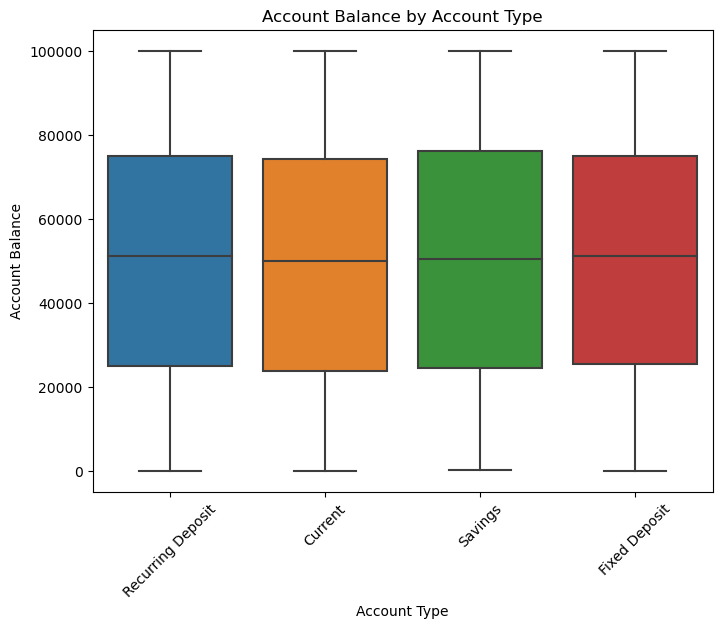

In [190]:
# Boxplot of Account Balance by Account Type
plt.figure(figsize=(8, 6))
sns.boxplot(x='Account Type', y='Account Balance', data=df)
plt.title('Account Balance by Account Type')
plt.xticks(rotation=45)
plt.show()

Brak outlierów. Rozkład stanu konta w zależności od typu konta

In [191]:
# Cross-tabulation of Account Type and Transaction Type
print(pd.crosstab(df['Account Type'], df['Transaction Type']))

Transaction Type   Credit  Debit
Account Type                    
Current              1323   1206
Fixed Deposit        1266   1223
Recurring Deposit    1206   1196
Savings              1319   1261


Po równo.

## **Zamiana na jedną walutę i ponowne przeprowadzenie analizy**

In [192]:
# Approximate exchange rates to USD (update with current rates)
exchange_rates = {'USD': 1.0, 'EUR': 1.08, 'GBP': 1.27, 'INR': 0.012, 'JPY': 0.0066}

# Convert to USD
df['Transaction Amount USD'] = df.apply(lambda x: float(x['Transaction Amount']) * exchange_rates.get(x['Currency'], 1.0), axis=1)
df['Account Balance USD'] = df.apply(lambda x: float(x['Account Balance']) * exchange_rates.get(x['Currency'], 1.0), axis=1)

# Verify conversion
print(df[['Transaction Amount USD', 'Account Balance USD']].describe())


       Transaction Amount USD  Account Balance USD
count            10000.000000         10000.000000
mean              1704.556596         33910.047464
std               1870.159242         37213.913721
min                  0.082434             0.897336
25%                 26.736683           535.726967
50%                950.329000         18802.265000
75%               3277.854375         65177.548200
max               6347.510800        126968.999300


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account Type            10000 non-null  object 
 1   Branch                  10000 non-null  object 
 2   Transaction Type        10000 non-null  object 
 3   Transaction Amount      10000 non-null  float64
 4   Account Balance         10000 non-null  float64
 5   Currency                10000 non-null  object 
 6   Transaction Amount USD  10000 non-null  float64
 7   Account Balance USD     10000 non-null  float64
dtypes: float64(4), object(4)
memory usage: 625.1+ KB


In [194]:
df.head()

,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency,Transaction Amount USD,Account Balance USD
0,Recurring Deposit,New York,Debit,2687.19,36676.19,GBP,3412.73130,46578.76130
1,Recurring Deposit,Houston,Debit,3886.77,28582.82,USD,3886.77000,28582.82000
2,Current,New York,Credit,2438.74,76599.56,GBP,3097.19980,97281.44120
3,Recurring Deposit,Philadelphia,Credit,2758.53,62317.60,INR,33.10236,747.81120
4,Current,Philadelphia,Debit,3287.00,85515.21,INR,39.44400,1026.18252


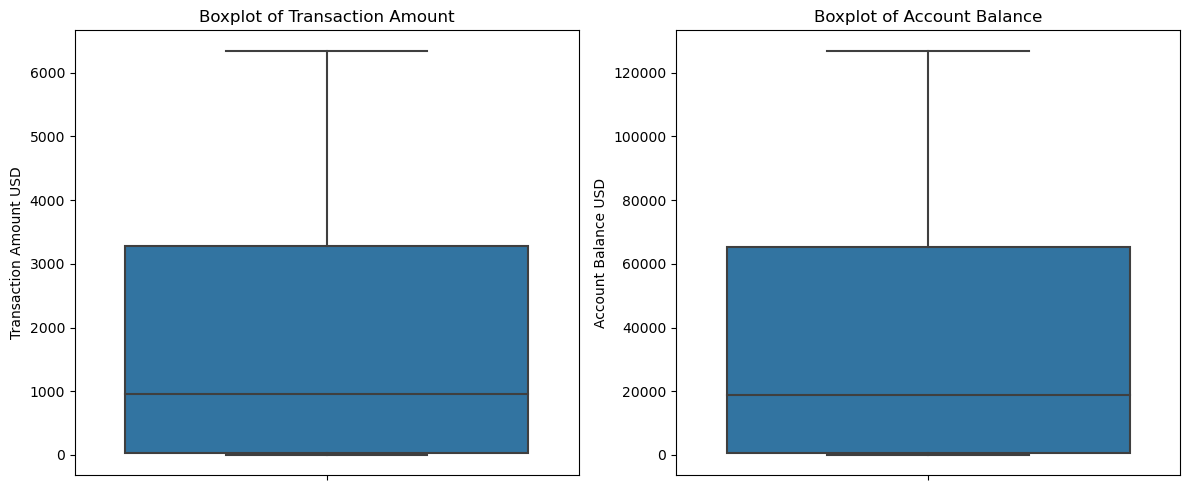

In [196]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Transaction Amount USD'])
plt.title('Boxplot of Transaction Amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Account Balance USD'])
plt.title('Boxplot of Account Balance')
plt.tight_layout()
plt.show()

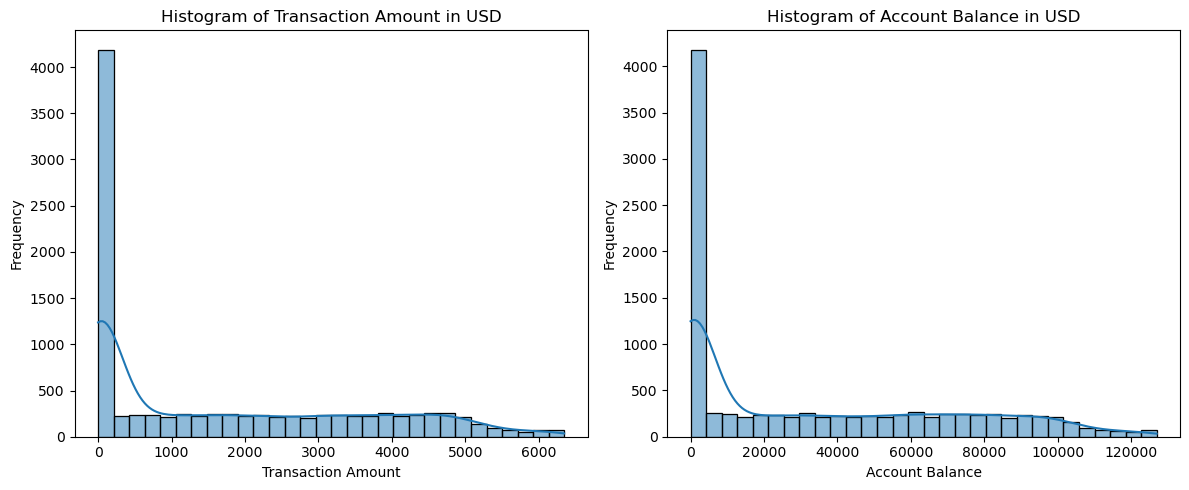

In [197]:
# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for Transaction Amount
plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount USD'], bins=30, kde=True)
plt.title('Histogram of Transaction Amount in USD')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Histogram for Account Balance
plt.subplot(1, 2, 2)
sns.histplot(df['Account Balance USD'], bins=30, kde=True)
plt.title('Histogram of Account Balance in USD')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Bardzo mocna skośność, można rozważyć logarytmowanie w MILESTONE2

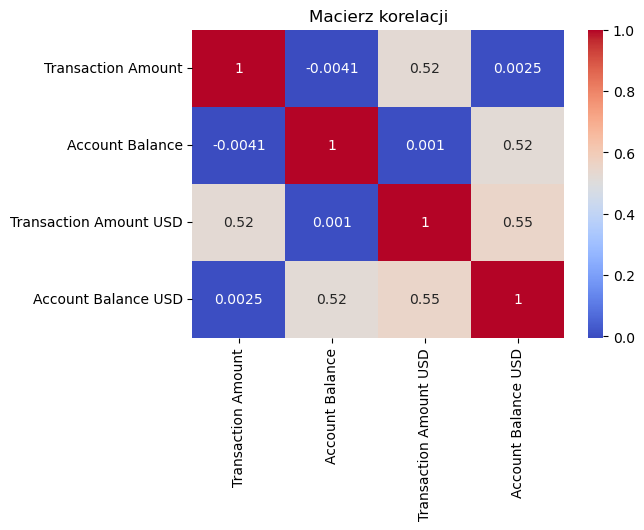

In [198]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

**Przeskalowanie wartości** dla wartości numerycznych sprowadzając wszystko do jednej waluty daje ciekawe i przydatne informacje. W przyszłości można rozważyć zastosować logarytm. 

# CZY PRZESKALOWANIE TO NA PEWNO DOBRY POMYSŁ - poproszę o opinię

### Co można do MILESTONE2 czyli inżynierii cech:

In [195]:
# df['Balance_to_Transaction_Ratio'] = df['Account Balance USD'] / df['Transaction Amount USD']

# df['Is_Credit'] = df['Transaction Type'].apply(lambda x: 1 if x == 'Credit' else 0)